# Chapter 5c: 1-D CNN application to earthquake P-wave arrival picking

CNNs were developed for image classification problems, where the model learns an internal representation of a two-dimensionsal input, in the so-called process of feature learning. This same process can be harnessed on one-dimensional sequences of data.

In the present notebook, we will develop and test a one-dimensional convolutional neural network (1-D CNN) for P-wave arrival picking in a database of seismic waveforms.

We will again use the _STanford EArthquake Dataset (STEAD)_ (Mousavi et al., 2019) (see chapter 4d). Our goal is to reproduce the study of Ross et al. (2018), titled '_P Wave Arrival Picking and First-Motion Polarity Determination With Deep Learning_'.

<img src="figs_notebook/ref_Ross.png" width = 700>

In this notebook, we will further explore the STEAD dataset, create our first 1-D CNN, and for the first time apply data augmentation to improve traning and hence model precision. As we do not use the same dataset as in Ross et al. (2018), we should not expect to obtain the exact same results. Our goal will be to apply different techniques so that we can increase precision the best that we can.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as plt_col

import h5py
import glob
import csv

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D

import statistics as stat

## 1. Load, filter & visualize STEAD dataset

The _STanford EArthquake Dataset_ (STEAD) is a global dataset of seismic signals for AI. It is a high-quality, large-scale, and global data set of local earthquake and non-earthquake signals recorded by seismic instruments. The dataset in its current state contains two categories: (1) local earthquake waveforms (recorded at 'local' distances within 350 km of earthquakes) and (2) seismic noise waveforms that are free of earthquake signals. Together these data comprise ~ 1.2 million time series or more than 19,000 hours of seismic signal recordings. The dataset facilitates training, validation, and performance comparisons.

The seismic data are defined as individual NumPy arrays containing 3 1-minute-long waveforms for each of the 3 ground motion components (east-west, north-south, and vertical directions respectively). All seismograms (earthquake and non-earthquake) are resampled to 100 Hz, meaning 6000 samples for a 60-second duration (where the time of first sample is given by `trace_start_time` in UTC). The category of each seismogram (`trace_category`) and its name (`trace_name`) are given in the data attributes. The `trace_name` is a unique name containing station, network, recording time, and category code (`'EV'` for earthquake and `'NO'` for noise data). The sample points where P and S phases arrive (`p_arrival_sample` and `s_arrival_sample`) are provided while status (`p_status` and `s_status`) shows how these arrival times have been determined.

The data set contains seismograms associated with a wide range of earthquake sizes from magnitude −0.5 to magnitude 7.9, but small earthquakes (magnitudes < 2.5) comprise the majority of the data set.

See the notebook of chapter 4d to learn how to download STEAD. Here, simply move your `data/STEAD` folder from your chapter 4 folder to the new chapter 5 folder where the present jupyter notebook is located.

Below, we first load the data.

In [2]:
## modified from https://github.com/smousavi05/STEAD ##
file_name = "data/STEAD/chunk2.hdf5"
csv_file = "data/STEAD/chunk2.csv"

# reading the csv file into a dataframe:
df = pd.read_csv(csv_file)
print(f'total events in csv file: {len(df)}')
# filterering the dataframe
df_EQ = df[(df.trace_category == 'earthquake_local') & (df.source_distance_km <= 20) & (df.source_magnitude > 3)]
#df_noise = df[(df.trace_category == 'noise') & (df.receiver_code == 'PHOB') ]
print(f'total earthquake time series selected: {len(df_EQ)}')
#print(f'total noise time series selected: {len(df_noise)}')

# making a list of trace names for the selected data
EQ_list = df_EQ['trace_name'].to_list()
#noise_list = df_noise['trace_name'].to_list()[:200]

sampling_rate = 100    #Hz

total events in csv file: 200000
total earthquake time series selected: 268


/Users/arnaudmignan/miniforge3/envs/env_tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


There are 35 attributes (labels) for each earthquake associated with each NumPy array. In addition to the station information (e.g. network code, code, type, and location of the receiver), information about the earthquake includes: origin time, epicentral location, depth, magnitude, magnitude type, focal mechanism, arrival times of P and S phases, estimated errors, etc., and recorded signal (e.g. measurement of the signal-to-noise ratio for each component, the end of signal’s dominant energy (coda-end), and epicentral distance). The unit of each attribute is included in the attribute’s name. Each window contains both P and S waves and begins from 5 to 10 seconds prior to the P arrival and ends at least 5 second after the S arrival.

Our goal will be to predict the P arrival time (blue vertical line)

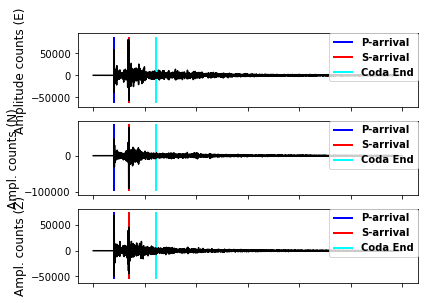

In [3]:
## from https://github.com/smousavi05/STEAD ##

# retrieving selected waveforms from the hdf5 file: 
evi = EQ_list[0]
dtfl = h5py.File(file_name, 'r')
dataset = dtfl.get('data/' + str(evi)) 

# waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel 
data = np.array(dataset)

fig = plt.figure()
ax = fig.add_subplot(311)         
plt.plot(data[:,0], 'k')
plt.rcParams["figure.figsize"] = (17, 12)
legend_properties = {'weight':'bold'}    
plt.tight_layout()
ymin, ymax = ax.get_ylim()
pl = plt.vlines(dataset.attrs['p_arrival_sample'], ymin, ymax, color='b', linewidth=2, label='P-arrival')
sl = plt.vlines(dataset.attrs['s_arrival_sample'], ymin, ymax, color='r', linewidth=2, label='S-arrival')
cl = plt.vlines(dataset.attrs['coda_end_sample'], ymin, ymax, color='aqua', linewidth=2, label='Coda End')
plt.legend(handles=[pl, sl, cl], loc = 'upper right', borderaxespad=0., prop=legend_properties)        
plt.ylabel('Amplitude counts (E)', fontsize=12) 
ax.set_xticklabels([])

ax = fig.add_subplot(312)         
plt.plot(data[:,1], 'k')
plt.rcParams["figure.figsize"] = (17, 12)
legend_properties = {'weight':'bold'}    
plt.tight_layout()
ymin, ymax = ax.get_ylim()
pl = plt.vlines(dataset.attrs['p_arrival_sample'], ymin, ymax, color='b', linewidth=2, label='P-arrival')
sl = plt.vlines(dataset.attrs['s_arrival_sample'], ymin, ymax, color='r', linewidth=2, label='S-arrival')
cl = plt.vlines(dataset.attrs['coda_end_sample'], ymin, ymax, color='aqua', linewidth=2, label='Coda End')
plt.legend(handles=[pl, sl, cl], loc = 'upper right', borderaxespad=0., prop=legend_properties)        
plt.ylabel('Ampl. counts (N)', fontsize=12) 
ax.set_xticklabels([])
    
ax = fig.add_subplot(313)         
plt.plot(data[:,2], 'k')
plt.rcParams["figure.figsize"] = (17, 12)
legend_properties = {'weight':'bold'}    
plt.tight_layout()
ymin, ymax = ax.get_ylim()
pl = plt.vlines(dataset.attrs['p_arrival_sample'], ymin, ymax, color='b', linewidth=2, label='P-arrival')
sl = plt.vlines(dataset.attrs['s_arrival_sample'], ymin, ymax, color='r', linewidth=2, label='S-arrival')
cl = plt.vlines(dataset.attrs['coda_end_sample'], ymin, ymax, color='aqua', linewidth=2, label='Coda End')
plt.legend(handles=[pl, sl, cl], loc = 'upper right', borderaxespad=0., prop=legend_properties)        
plt.ylabel('Ampl. counts (Z)', fontsize=12) 
ax.set_xticklabels([])
plt.show() 

## 2. P wave arrival picking

### 2.1. STA-LTA baseline model

The simple __ratio of Short-Term-Average to Long-Term-Average (STA/LTA)__ filter is a popular and simple way to detect transient seismic events (Allen, 1982). The algorithm continuously calculates the average values of the absolute amplitude of a seismic signal in two consecutive moving-time windows. The short time window (STA) is sensitive to seismic events while the long time window (LTA) provides information about the temporal amplitude of seismic noise at the site. When the ratio of both exceeds a pre-set value, an event is 'declared'.

In [4]:
## function from https://github.com/obspy/obspy/blob/master/obspy/signal/trigger.py ##

def recursive_sta_lta_py(a, nsta, nlta):
    """
    Recursive STA/LTA written in Python.
    :type a: NumPy :class:`~numpy.ndarray`
    :param a: Seismic Trace
    :type nsta: int
    :param nsta: Length of short time average window in samples
    :type nlta: int
    :param nlta: Length of long time average window in samples
    :rtype: NumPy :class:`~numpy.ndarray`
    :return: Characteristic function of recursive STA/LTA
    .. seealso:: [Withers1998]_ (p. 98) and [Trnkoczy2012]_
    """
    try:
        a = a.tolist()
    except Exception:
        pass
    ndat = len(a)
    # compute the short time average (STA) and long time average (LTA)
    # given by Evans and Allen
    csta = 1. / nsta
    clta = 1. / nlta
    sta = 0.
    lta = 1e-99  # avoid zero division
    charfct = [0.0] * len(a)
    icsta = 1 - csta
    iclta = 1 - clta
    for i in range(1, ndat):
        sq = a[i] ** 2
        sta = csta * sq + icsta * sta
        lta = clta * sq + iclta * lta
        charfct[i] = sta / lta
        if i < nlta:
            charfct[i] = 0.
    return np.array(charfct)

**EXERCISE 1:** Reproduce the STA-LTA baseline model that we did in the notebook of chapter 4d. Describe its outcome by giving the standard deviation of the residual $y_{pred}-y_{obs}$ in seconds.

In [5]:
# YOUR CODE HERE



# SOLUTION
threshold = 2
n = len(EQ_list)

y_obs = np.empty(shape = (n, 1))
y_pred = np.empty(shape = (n, 1))
for i in range(n):
    evi = EQ_list[i]
    dtfl = h5py.File(file_name, 'r')
    dataset = dtfl.get('data/' + str(evi)) 

    # waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel 
    data = np.array(dataset)
    
    y_obs[i] = dataset.attrs['p_arrival_sample']
    
    STALTA = recursive_sta_lta_py(data[:,0], 2 * sampling_rate, 5 * sampling_rate)
    ind = np.argwhere(STALTA > threshold)
    if len(ind) != 0:
        y_pred[i] = ind[0]

residual = (y_pred - y_obs)/sampling_rate
print('Standard deviation:', np.std(residual))

Standard deviation: 1.7939862863188534


**EXERCISE 2:** Plot the histogram of the residual.

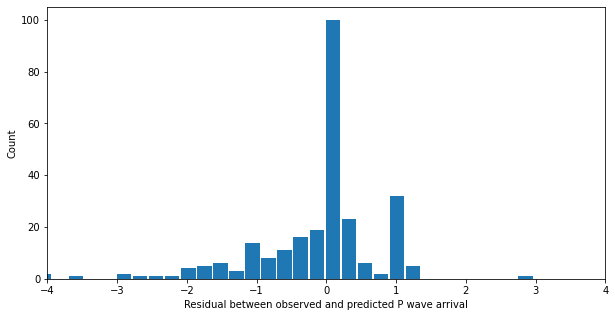

In [6]:
# YOUR CODE HERE



# SOLUTION
fig = plt.figure(figsize = (10,5))
plt.hist(residual, bins = 100, rwidth = .9)
plt.xlim(-4, 4)
plt.xlabel('Residual between observed and predicted P wave arrival')
plt.ylabel('Count');

The results of the baseline model are bad since we did not optimize the STA-LTA model, as it is outside the scope of this course. But we will now see how much better a CNN can do. Notice however that our CNN results will likely not reach the precision level obtained by Ross et al. (2018) since we use much less samples. Using millions of samples as done in that publication would require GPU processing.

### 2.2. 1-D CNN of Ross et al. (2018)

Ross et al. (2018) only used the vertical component of the sensor on which the analyst picked the arrival times. Rather than split the data evenly between the two sets, they chose to have the training set consist of 75% of the records, with the remaining 25% forming the validation set. They then selected a 4-s-long feature window centered on the P wave arrival (sampling rate of 100Hz as in STEAD). In order to mimic the situation where the true pick time is unknown, they perturbed the center of the feature window with a uniform random perturbation shift between -0.5 and 0.5 s. The amplitudes in each feature window were normalized by the peak absolute amplitude in the window. This helps to suppress the influence of amplitude variations with magnitude, distance, and other factors and is motivated by the bounded gray scale range [0, 1] used in image recognition algorithms (although here the range is $[-1, 1]$).

**EXERCISE 3:** Plot some examples of input samples for the CNN, based on the information given above. _Hints:_ Calculate the window size (or number of input features) first. To perturb the P wave time, first center the window on the P wave arrival, then use `np.random.randint()`.

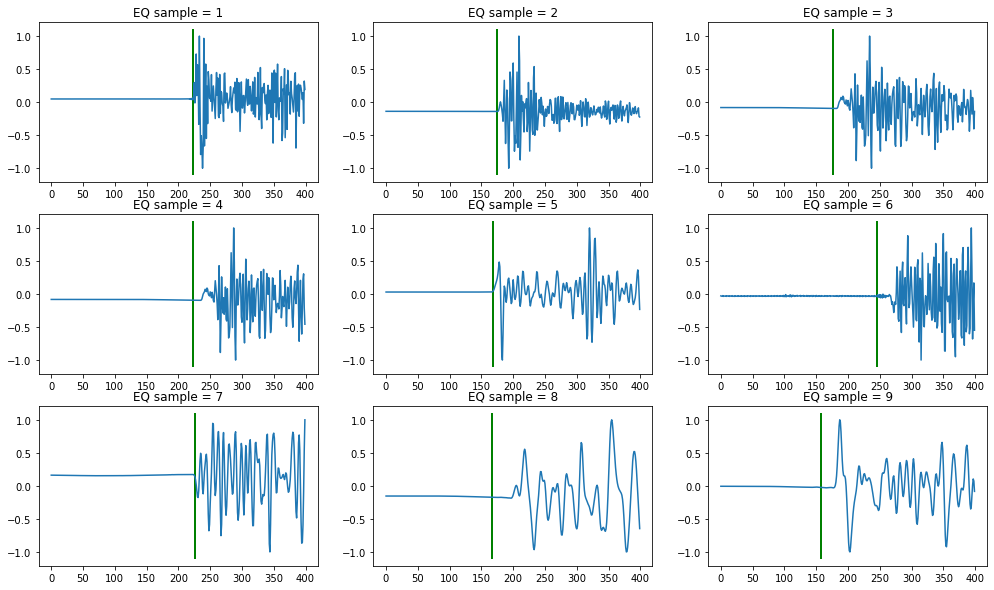

In [7]:
# YOUR CODE HERE
#win_size = ?

#nrow = 3
#ncol = 3
#fig, ax = plt.subplots(nrow, ncol, figsize=(17, 10))
#k = 0
#for i in range(nrow):
#    for j in range(ncol):
#        k = k+1
#        evi = EQ_list[k]
#        dtfl = h5py.File(file_name, 'r')
#        dataset = dtfl.get('data/' + str(evi)) 
        # waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel 
#        data = np.array(dataset)

#        u = ?
#        beforeP = dataset.attrs['p_arrival_sample'] - ?
#        afterP = dataset.attrs['p_arrival_sample'] + ?
#        indwin = ?
#        P0 = ?

#        data_norm = ? * (data[?,?] - np.min(data[?,?]))/(np.max(data[?,?] - np.min(data[?,?]))) - ?
        
#        ax[i,j].plot(data_norm)
#        ymin, ymax = ax[i,j].get_ylim()
#        pobs = ax[i,j].vlines(P0, ymin, ymax, color='g', linewidth=2, label='y obs')
#        ax[i,j].set_title('EQ sample = {0}'.format(k))




# SOLUTION
win_size = 400

nrow = 3
ncol = 3
fig, ax = plt.subplots(nrow, ncol, figsize=(17, 10))
k = 0
for i in range(nrow):
    for j in range(ncol):
        k = k+1
        evi = EQ_list[k]
        dtfl = h5py.File(file_name, 'r')
        dataset = dtfl.get('data/' + str(evi)) 
        # waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel 
        data = np.array(dataset)

        u = np.random.randint(100)-50
        beforeP = dataset.attrs['p_arrival_sample'] - win_size/2 + u
        afterP = dataset.attrs['p_arrival_sample'] + win_size/2 + u
        indwin = range(round(beforeP), round(afterP))
        P0 = win_size/2 - u

        data_norm = 2*(data[indwin,2] - np.min(data[indwin,2]))/(np.max(data[indwin,2] - np.min(data[indwin,2])))-1
        
        ax[i,j].plot(data_norm)
        ymin, ymax = ax[i,j].get_ylim()
        pobs = ax[i,j].vlines(P0, ymin, ymax, color='g', linewidth=2, label='y obs')
        ax[i,j].set_title('EQ sample = {0}'.format(k))

**EXERCISE 4:** Generate the data set with `X` of shape `(number of samples, number of input features, 1)` and `y` of shape `(number of samples, 1)`. Then split it following the same approach as in Ross et al. (2018).

In [8]:
# YOUR CODE HERE
#nEQ = len(df_EQ)
#X = np.empty(shape = (?, ?, ?))
#y = np.empty(shape = (?, ?))

#for i in range(nEQ):
#    evi = EQ_list[i]
#    dtfl = h5py.File(file_name, 'r')
#    dataset = dtfl.get('data/' + str(evi)) 
    # waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel 
#    data = np.array(dataset)

#    u = ?
#    beforeP = dataset.attrs['p_arrival_sample'] - ?
#    afterP = dataset.attrs['p_arrival_sample'] + ?
#    indwin = ?
#    P0 = ?
    
#    data_norm = ? * (data[?,?] - np.min(data[?,?]))/(np.max(data[?,?] - np.min(data[?,?]))) - ?

#    X[?,?,?] = ?
#    y[?,?] = ?


# SOLUTION
nEQ = len(df_EQ)
X = np.empty(shape = (nEQ, win_size, 1))
y = np.empty(shape = (nEQ, 1))

for i in range(nEQ):
    evi = EQ_list[i]
    dtfl = h5py.File(file_name, 'r')
    dataset = dtfl.get('data/' + str(evi)) 
    # waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel 
    data = np.array(dataset)

    u = np.random.randint(100)-50
    beforeP = dataset.attrs['p_arrival_sample'] - win_size/2 + u
    afterP = dataset.attrs['p_arrival_sample'] + win_size/2 + u
    indwin = range(round(beforeP), round(afterP))
    P0 = round(win_size/2 - u)
    
    data_norm = 2*(data[indwin,2] - np.min(data[indwin,2]))/(np.max(data[indwin,2] - np.min(data[indwin,2])))-1

    X[i,:,0] = data_norm
    y[i,0] = P0

In [9]:
# YOUR CODE HERE - train/test split


# SOLUTION
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)
X_train.shape

(201, 400, 1)

<img src="figs_notebook/ref_Ross_CNNarchitecture.png" width = 700>

Cartoon depicting the CNN workflow for arrival time picking by Ross et al. (2018): In the first convolution step, the input seismogram is filtered in parallel with n = 32 different filters with a length of 21 samples each. The filter specifications themselves are learned during the model training. The output of each filter is down-sampled in a subsequent pooling step by retaining the maximum of any two neighboring samples (“max pooling”). The process is repeated several times more, after which the output signals are concatenated and used as the input for a fully connected (FC) neural network.

From the text we additionally learn: The 400 waveform amplitude samples of each seismogram are the features that we use as input data. The convolution and full-connected layers use rectified linear units (ReLUs) as the activation function, while the output layer uses linear activation (i.e. for regression). The training is performed using the Adam stochastic optimization algorithm.

Finally their Table 1 provides everything else that we need to reproduce their model:

<img src="figs_notebook/ref_Ross_table.png" width = 400>

**EXERCISE 5:** Build a 1-D CNN following the description given above and compile it. _Hints:_ You must use `Conv1D` and `MaxPooling1D`. For a regression, you can use `metrics = ['mse']` and `loss = 'mean_squared_error'` in the compiler.

In [10]:
# YOUR CODE HERE





# SOLUTION
model = Sequential()
model.add(Conv1D(filters = 32, kernel_size = 21, activation = 'relu', input_shape = (win_size, 1)))
model.add(MaxPooling1D(pool_size = 2))
model.add(Conv1D(filters = 64, kernel_size = 15, activation = 'relu'))
model.add(MaxPooling1D(pool_size = 2))
model.add(Conv1D(filters = 128, kernel_size = 11, activation = 'relu'))
model.add(MaxPooling1D(pool_size = 2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse'])

**EXERCISE 6:** Train the model, predict on the test set, and print the standard deviation of the residual between predicted and observed P wave arrivals. Save the results of the model fit to print the learning curve in the next exercise.

In [11]:
epochs = 200
batch_size = 200

# YOUR CODE HERE




# SOLUTION
results = model.fit(
    X_train, y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (X_test, y_test),
    verbose = 0   # 0 to hide the training progress, 1 otherwise
)

y_pred = model.predict(X_test)

residual = (y_pred - y_test)/sampling_rate
print('Standard deviation:', np.std(residual))

Standard deviation: 0.3715300999434778


**EXERCISE 7:** Plot the learning curve.

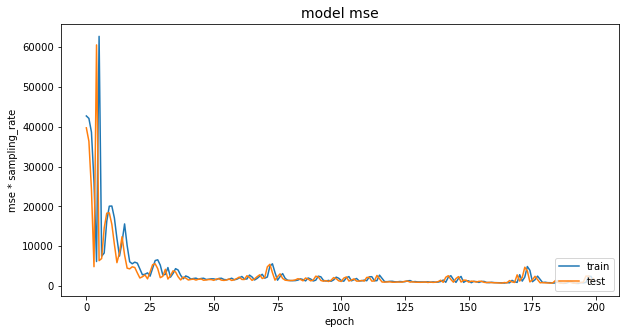

In [12]:
# YOUR CODE HERE




# SOLUTION
fig = plt.figure(figsize = (10,5))
plt.plot(results.history['mse'])
plt.plot(results.history['val_mse'])
plt.xlabel('epoch')
plt.ylabel('mse * sampling_rate')
plt.title('model mse', size=14)
plt.legend(['train', 'test'], loc='lower right');

**EXERCISE 8:** Plot the histogram of the residual in 2 subplots, the top panel with the same x-axis range as in exercise 2 for direct comparison with the baseline model, the bottom panel with a shorter range.

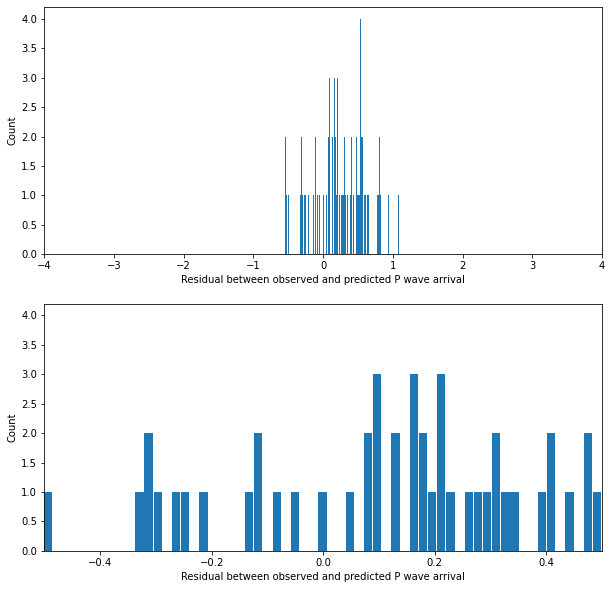

In [13]:
# YOUR CODE HERE




# SOLUTION
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].hist(residual, bins = 100, rwidth = .9)
axs[0].set_xlim(-4, 4)
axs[0].set_xlabel('Residual between observed and predicted P wave arrival')
axs[0].set_ylabel('Count')

axs[1].hist(residual, bins = 100, rwidth = .9)
axs[1].set_xlim(-.5, .5)
axs[1].set_xlabel('Residual between observed and predicted P wave arrival')
axs[1].set_ylabel('Count');

**EXERCISE 9:** Plot some examples of seismic waveforms with both observed and predicted P arrivals.

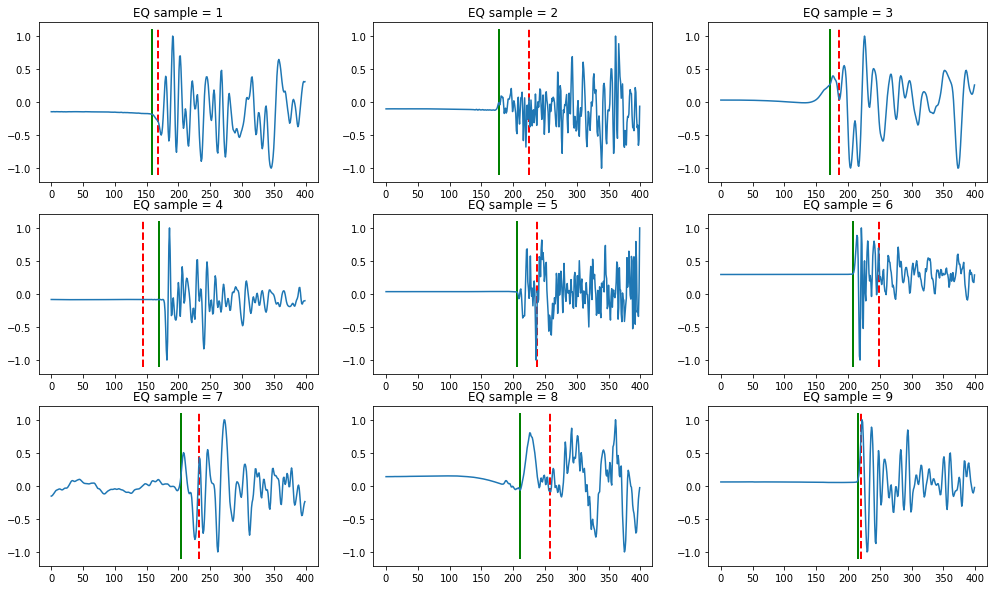

In [14]:
# YOUR CODE HERE




# SOLUTION
nrow = 3
ncol = 3
fig, ax = plt.subplots(nrow, ncol, figsize=(17, 10))
k = 0
for i in range(nrow):
    for j in range(ncol):
        k = k+1
        
        ax[i,j].plot(X_test[k,:,0])
        ymin, ymax = ax[i,j].get_ylim()
        pobs = ax[i,j].vlines(y_test[k], ymin, ymax, color='g', linewidth=2)
        pobs = ax[i,j].vlines(y_pred[k], ymin, ymax, color='r', linewidth=2, linestyle = '--')
        ax[i,j].set_title('EQ sample = {0}'.format(k))

### 2.3. Data augmentation

In the training data set, Ross et al. (2018) used each seismogram five times with different random windows, which artificially expanded the training data set.

**EXERCISE 10:** Find an approach to increase the dataset for training by tenfold minimum. Prepare the new dataset.

In [15]:
# YOUR CODE HERE




# SOLUTION
win_size = 400

nEQ = len(df_EQ)
ampl = 10
nDA = nEQ * ampl
X = np.empty(shape = (nDA, win_size, 1))
y = np.empty(shape = (nDA, 1))

k = 0
for i in range(nEQ):
    evi = EQ_list[i]
    dtfl = h5py.File(file_name, 'r')
    dataset = dtfl.get('data/' + str(evi)) 
    # waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel 
    data = np.array(dataset)

    for j in range(ampl):
        u = np.random.randint(100)-50
        beforeP = dataset.attrs['p_arrival_sample'] - win_size/2 + u
        afterP = dataset.attrs['p_arrival_sample'] + win_size/2 + u
        indwin = range(round(beforeP), round(afterP))
        P0 = round(win_size/2 - u)
    
        data_norm = 2*(data[indwin,2] - np.min(data[indwin,2]))/(np.max(data[indwin,2] - np.min(data[indwin,2])))-1

        X[k,:,0] = data_norm
        y[k,0] = P0
        k = k+1

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)
X_train.shape

(2010, 400, 1)

**EXERCISE 11:** Rerun the CNN model and compare with the previous results (by providing the standard deviation of the residual, the learning curve, the histogram of residuals and finally some examples). _Hint:_ call the new residual estimates `residual_new` or any other name than the previous residuals for comparison.

In [17]:
model = Sequential()
model.add(Conv1D(filters = 32, kernel_size = 21, activation = 'relu', input_shape = (win_size, 1)))
model.add(MaxPooling1D(pool_size = 2))
model.add(Conv1D(filters = 64, kernel_size = 15, activation = 'relu'))
model.add(MaxPooling1D(pool_size = 2))
model.add(Conv1D(filters = 128, kernel_size = 11, activation = 'relu'))
model.add(MaxPooling1D(pool_size = 2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse'])

In [ ]:
# YOUR CODE HERE - training and prediction




# SOLUTION
epochs = 100         #200/200 0.06 precision
batch_size = 200
results = model.fit(
    X_train, y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (X_test, y_test),
    verbose = 0   # 0 to hide the training progress, 1 otherwise
)

y_pred = model.predict(X_test)

residual_new = (y_pred - y_test)/sampling_rate
print('Standard deviation:', np.std(residual_new))

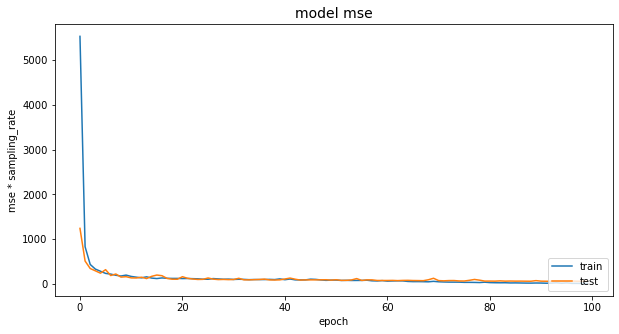

In [19]:
# YOUR CODE HERE - learning curve



# SOLUTION
fig = plt.figure(figsize = (10,5))
plt.plot(results.history['mse'])
plt.plot(results.history['val_mse'])
plt.xlabel('epoch')
plt.ylabel('mse * sampling_rate')
plt.title('model mse', size=14)
plt.legend(['train', 'test'], loc='lower right');


In [ ]:
# YOUR CODE HERE - histograms




# SOLUTION
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].hist(residual, bins = 100, rwidth = .9)
axs[0].set_xlim(-.5, .5)
axs[0].set_xlabel('Residual between observed and predicted P wave arrival')
axs[0].set_ylabel('Count')
axs[0].set_title('Original data')

axs[1].hist(residual_new, bins = 100, rwidth = .9)
axs[1].set_xlim(-.5, .5)
axs[1].set_xlabel('Residual between observed and predicted P wave arrival')
axs[1].set_ylabel('Count')
axs[1].set_title('Augmented data');

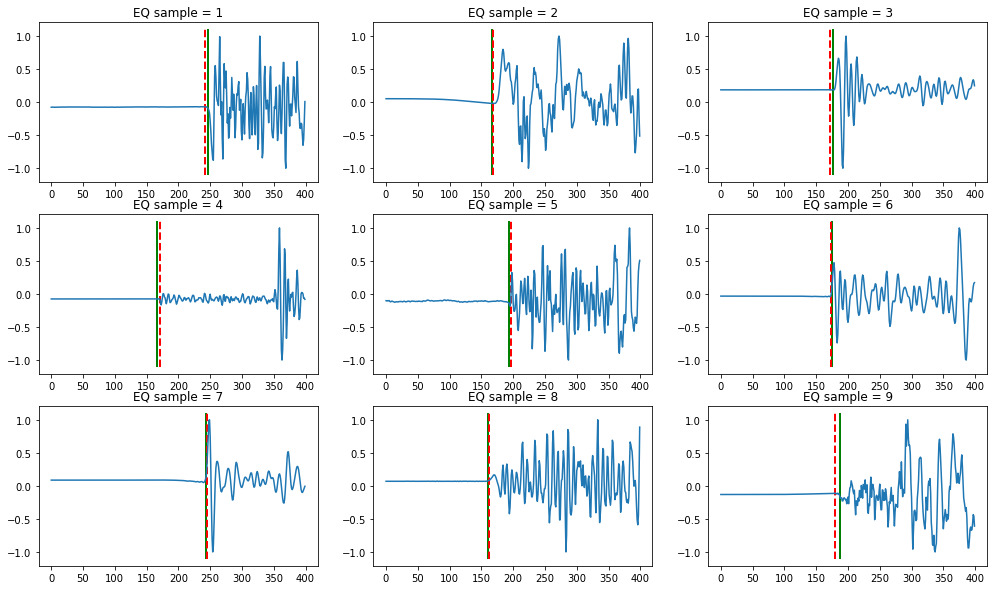

In [21]:
# YOUR CODE HERE - examples




# SOLUTION
nrow = 3
ncol = 3
fig, ax = plt.subplots(nrow, ncol, figsize=(17, 10))
k = 0
for i in range(nrow):
    for j in range(ncol):
        k = k+1
        
        ax[i,j].plot(X_test[k,:,0])
        ymin, ymax = ax[i,j].get_ylim()
        pobs = ax[i,j].vlines(y_test[k], ymin, ymax, color='g', linewidth=2)
        pobs = ax[i,j].vlines(y_pred[k], ymin, ymax, color='r', linewidth=2, linestyle = '--')
        ax[i,j].set_title('EQ sample = {0}'.format(k))

### 2.4. Feature maps

**EXERCISE 12:** Based on what you learned in the previous notebook (chap5b), plot some examples of feature maps learned by the 1-D CNN for each one of the 3 CONV layers.

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE ...

In [22]:
# SOLUTION
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

0 conv1d_3 (None, 380, 32)
2 conv1d_4 (None, 176, 64)
4 conv1d_5 (None, 78, 128)


In [23]:
from keras.models import Model

# redefine model to output right after the first hidden layer
model_getFeatureMaps1 = Model(inputs=model.inputs, outputs=model.layers[0].output)
model_getFeatureMaps2 = Model(inputs=model.inputs, outputs=model.layers[1].output)
model_getFeatureMaps3 = Model(inputs=model.inputs, outputs=model.layers[2].output)

(400,)

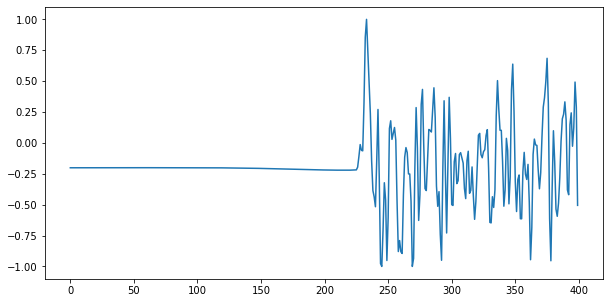

In [28]:
fig = plt.figure(figsize = (10,5))
timeseries = X_test[0,:,0]
plt.plot(timeseries);

timeseries.shape

In [30]:
from numpy import expand_dims

timeseries = expand_dims(timeseries, axis=0)
timeseries.shape

(1, 400)

In [34]:
feature_maps1 = model_getFeatureMaps1.predict(timeseries)
feature_maps2 = model_getFeatureMaps2.predict(timeseries)
feature_maps3 = model_getFeatureMaps3.predict(timeseries)

feature_maps1.shape

(1, 380, 32)

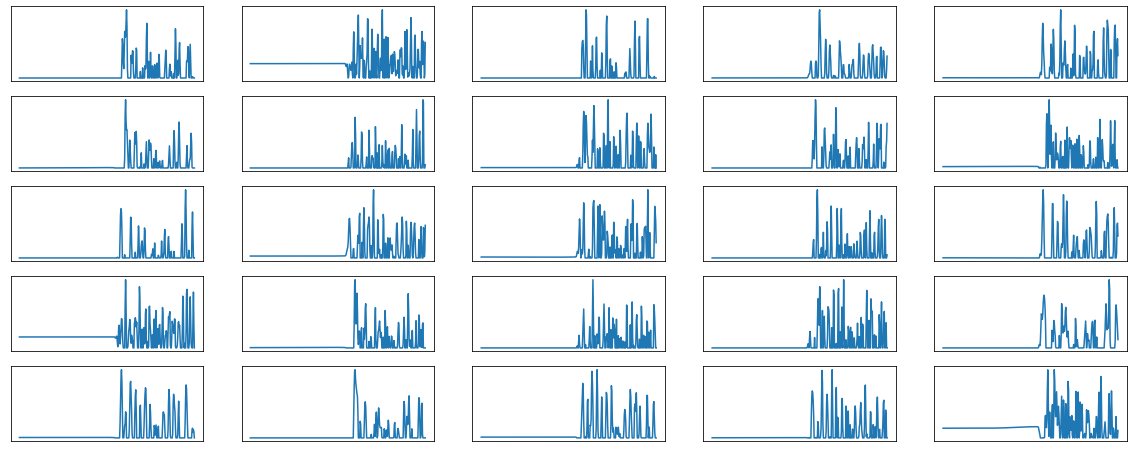

In [40]:
fig = plt.figure(figsize = (20,8))

square = 5
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.plot(feature_maps1[0, :, ix-1])
        ix += 1

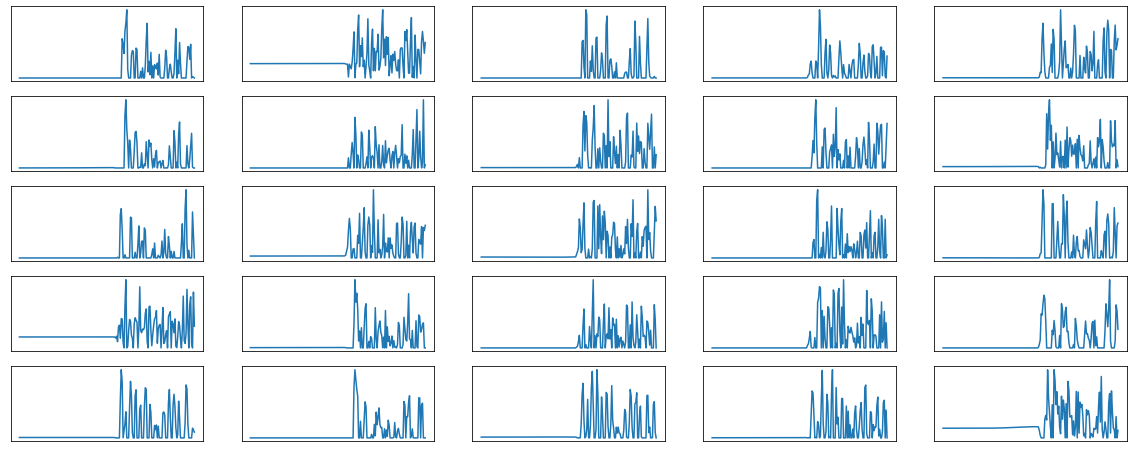

In [41]:
fig = plt.figure(figsize = (20,8))

square = 5
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.plot(feature_maps2[0, :, ix-1])
        ix += 1

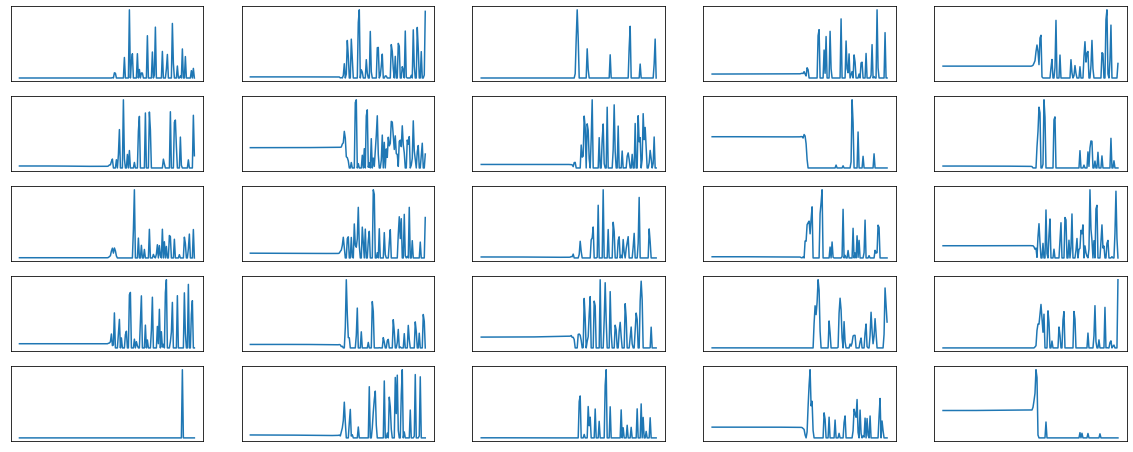

In [42]:
fig = plt.figure(figsize = (20,8))

square = 5
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.plot(feature_maps3[0, :, ix-1])
        ix += 1

## References

* Allen (1982), Automatic phase pickers: Their present use and future prospects, Bull. Seismol. Soc. Am., 72 (6), S225-S242
* Mousavi et al. (2019), STanford EArthquake Dataset (STEAD): A Global Data Set of Seismic Signals for AI, IEEE Access, 7, 179464-179476
* Ross et al. (2018), P Wave Arrival Picking and First-Motion Polarity Determination With Deep Learning, J. Geophys. Res. Solid Earth, 123, 5120–5129
* STanford EArthquake Dataset (STEAD): A Global Data Set of Seismic Signals for AI, available at https://github.com/smousavi05/STEAD